# Dataset

In [1]:
import numpy as np
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader, Subset
from dataset import HSIDataset
from torchvision.transforms import v2

path = '../../home/ivan/HELICoiD/HSI_Human_Brain_Database_IEEE_Access/'

dataset = HSIDataset(path)
dataset.normalize_dataset()

# Segmentation Model Split
# train_indices = list(range(0, 19))
# val_indices = list(range(19, 24))
# test_indices = list(range(24, 36))

# Autoencoder Split
train_indices = list(range(0, 33))
val_indices = list(range(33, 35))
test_indices = list(range(35, 36))

trainset = Subset(dataset, train_indices)
valset = Subset(dataset, val_indices)
testset = Subset(dataset, test_indices)

trainloader = DataLoader(trainset, batch_size=2, shuffle=True)
validationloader = DataLoader(valset, batch_size=2, shuffle=False)
testloader = DataLoader(testset, batch_size=2, shuffle=False)


/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


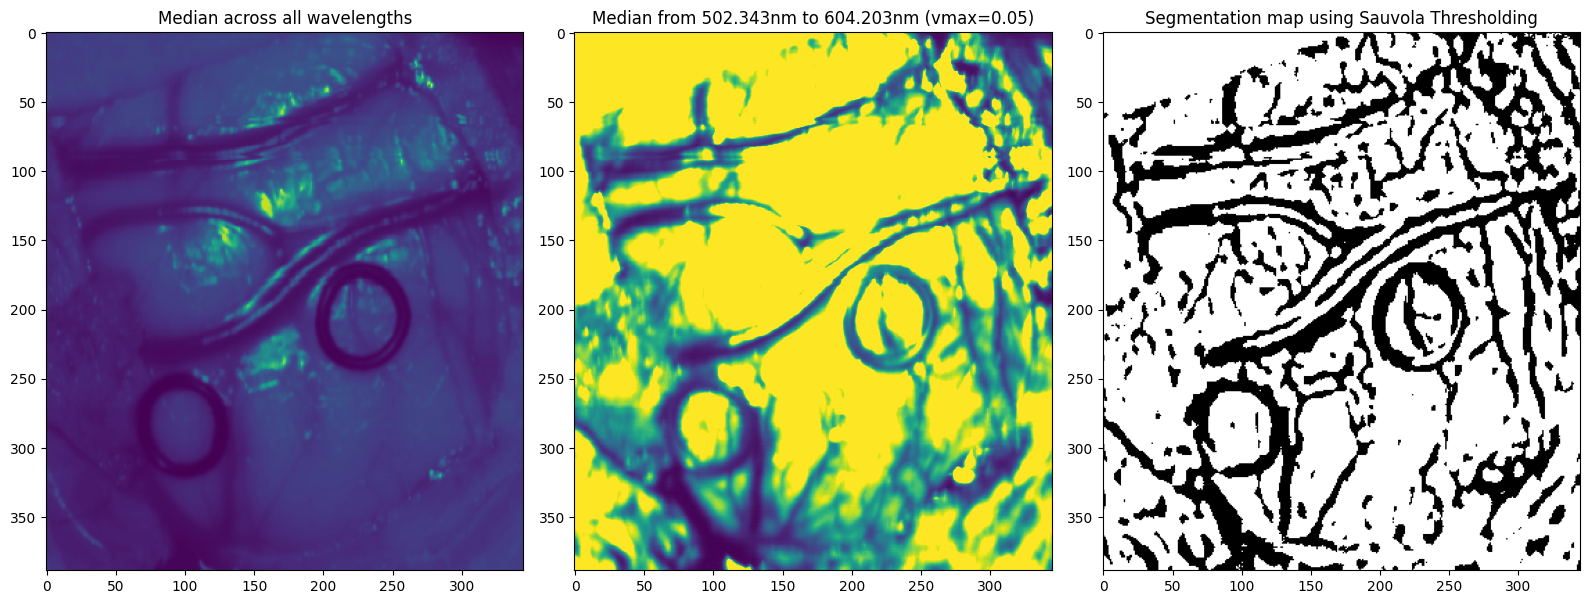

In [6]:
#patient = "012-02"
#patient = "025-02"
#patient = "015-01"
# patient = "012-01"
#patient = "016-04"
#patient = "008-01"
# patient = "020-01"
patient = "004-02"
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
import glob
import pickle
from scipy.linalg import pinv
import time
from tqdm import tqdm
from skimage import filters, color, io
from matplotlib.ticker import LinearLocator
import skimage

import pickle
import matplotlib.pyplot as plt
import random
from matplotlib.colors import Normalize
from PIL import Image
from spectral import open_image
import matplotlib.cm as cm


left=140
right=280
#left=200
#right=201
#left=520
#right=670


hdr_path = path+"/{}/raw.hdr".format(patient)
img = open_image(hdr_path)
wavelength = np.array(img.metadata['wavelength']).astype(float)
# print(wavelength[left])
# print(wavelength[right])
# print(np.where((wavelength >= 750) & (wavelength <= 850)))

white_path = path+"/{}/whiteReference.hdr".format(patient)
white = open_image(white_path)
white = white.load()

dark_path = path+"/{}/darkReference.hdr".format(patient)

dark = open_image(dark_path)
dark = dark.load()

white_full = np.tile(white, (img.shape[0],1,1))
dark_full = np.tile(dark, (img.shape[0],1,1))

img_normalized = ((img.load() - dark_full) / (white_full - dark_full))
#img_normalized = ((img.load() - dark_full) / (white_full - dark_full))+0.1
img_normalized[img_normalized <= 0] = 10**-2

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
axs[0].imshow(np.median(img_normalized,axis=2))
axs[0].set_title("Median across all wavelengths")
median_hb = (np.median(img_normalized[:,:,left:right],axis=2))
median_hb_normalized = (median_hb - np.min(median_hb))/(np.max(median_hb) - np.min(median_hb))
plt2 = axs[1].imshow(median_hb_normalized, vmax=0.05)
axs[1].set_title("Median from " + str(wavelength[left]) + "nm to " + str(wavelength[right]) + "nm (vmax=0.05)")
axs[2].imshow((median_hb_normalized > filters.threshold_sauvola(median_hb_normalized)), cmap='gray')
axs[2].set_title("Segmentation map using Sauvola Thresholding")
plt.tight_layout()
#plt.savefig(plot_dir + "segm")
#plt3 = axs[2].imshow((median_hb < 0.3)*median_hb)

# Visualize Data

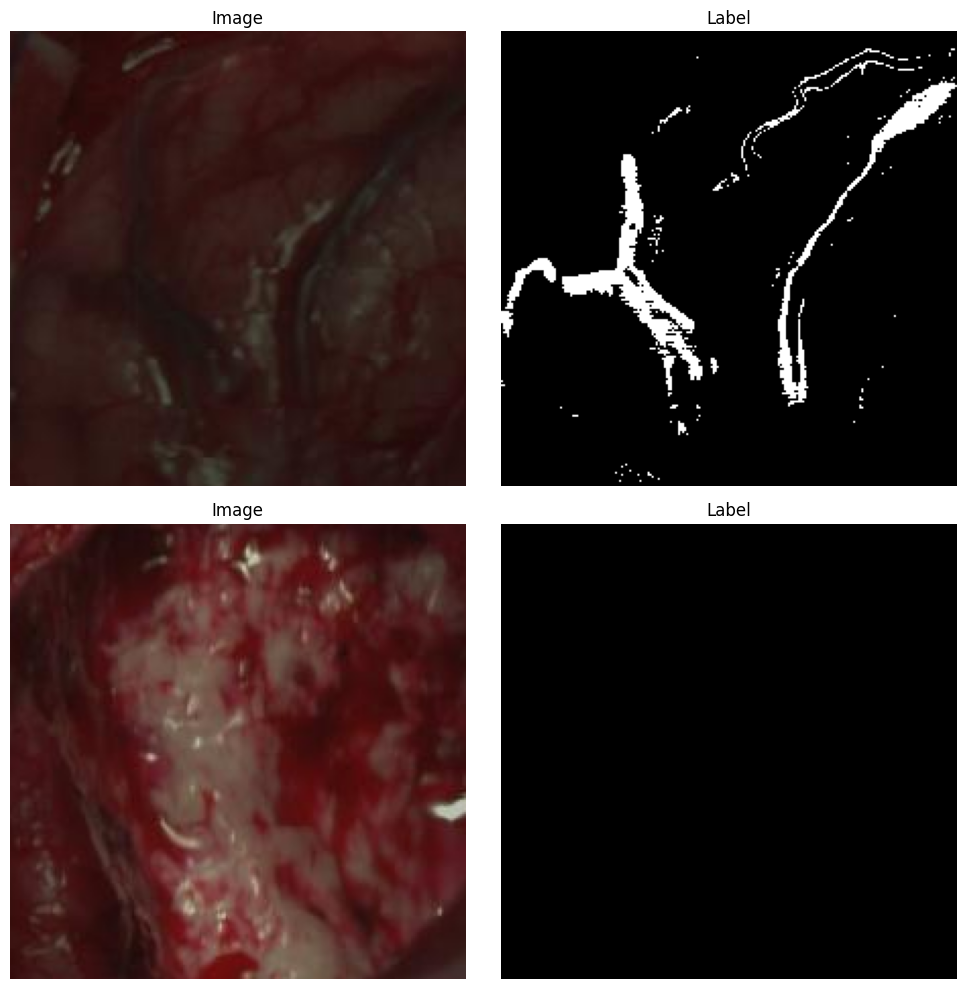

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_labels(labels):
    plt.imshow(labels.squeeze().numpy(), cmap='gray')
    plt.show()

def create_montage(dataset, num_images=10):
    # Define the number of images you want to show in the montage
    num_images = min(num_images, len(dataset))

    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    
    for i in range(num_images):
        sample = dataset[i]
        image, label = sample[2], sample[1]
        
        # Convert image and label to numpy arrays for plotting
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose(1, 2, 0)
        if isinstance(label, torch.Tensor):
            label = label.numpy().squeeze()
            overlay = np.zeros_like(image)
            overlay[label == 1] = [0, 255, 0]
        
        # Plot the image
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')
        
        # Plot the label
        axes[i, 1].imshow(label, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Label')
    
    plt.tight_layout()
    plt.show()

create_montage(valset, num_images=2)

# Model Initialization

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn
from segmentation_util import model_pipeline
import torch.nn.functional as F
from HSI_Net import HyperspectralToGrayscale, CombinedModel, ConvolutionalReducer, Unet

config = {
    'model': 'Test-model',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': 1,
    'optimizer': 'Adam',
    'criterion': 'BCELoss',
}

segmenter = smp.Unet('resnet34', in_channels=1, classes=1)
segmenter.load_state_dict(torch.load('./models/Unet-resnet34-DiceLoss/Unet-resnet34-DiceLoss_epoch10.pth'))
encoder = HyperspectralToGrayscale()
model = CombinedModel(encoder, segmenter)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Training

In [ ]:
import matplotlib.pyplot as plt
from segmentation_util import model_pipeline


model, train_losses, val_losses = model_pipeline(model, trainloader=trainloader, 
                                                 validationloader=validationloader, 
                                                 testloader=testloader, criterion=criterion, 
                                                 optimizer=optimizer,project='hsi-segmentation',
                                                 model_name=config['model'],
                                                 device=device, config=config, 
                                                 batch_print=1)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [ ]:
import torch
from HSI_Net import CombinedModel, HyperspectralToGrayscale, ConvolutionalReducer
from segmentation_util import predict, show_overlay
import segmentation_models_pytorch as smp
import cv2
import numpy as np
import matplotlib.pyplot as plt

encoder = HyperspectralToGrayscale()
segmenter = smp.Unet('resnet34', in_channels=1, classes=1)
# segmenter.load_state_dict(torch.load('./models/Unet-resnet34-DiceLoss/Unet-resnet34-DiceLoss_epoch10.pth'))
model = CombinedModel(encoder, segmenter)
model.load_state_dict(torch.load('./models/ConvLayer-Unet-resnet34/ConvLayer-Unet-resnet34_epoch10.pth'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

show_overlay(model, testset[0], device)

# Autoencoder Approach:
## Standard Autoencoder

In [2]:
from autoencoder import model_pipeline_autoencoder, Autoencoder
import torch.nn as nn
from torchsummary import summary

config = {
    'model': 'autoencoder-3-channels-with-normalized-cropped-data',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': trainloader.batch_size,
    'optimizer': 'Adam',
    'criterion': 'MSELoss',
}

autoencoder = Autoencoder(output_channels=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=config['learning_rate'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

autoencoder, train_losses, val_losses = model_pipeline_autoencoder(autoencoder,
                                                trainloader=trainloader, 
                                                validationloader=validationloader, 
                                                criterion=criterion, 
                                                optimizer=optimizer,
                                                project='hsi-autoencoder',
                                                model_name=config['model'],
                                                device=device, 
                                                config=config, 
                                                batch_print=1)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 1, Loss: 0.4467
Epoch 1, Batch 2, Loss: 3.4222
Epoch 1, Batch 3, Loss: 0.9284
Epoch 1, Batch 4, Loss: 0.3288
Epoch 1, Batch 5, Loss: 1.2936
Epoch 1, Batch 6, Loss: 0.8163
Epoch 1, Batch 7, Loss: 0.3468
Epoch 1, Batch 8, Loss: 0.5348
Epoch 1, Batch 9, Loss: 0.3419
Epoch 1, Batch 10, Loss: 0.3354


/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Epoch 1, Batch 11, Loss: 0.2628
Epoch 1, Batch 12, Loss: 0.2969
Epoch 1, Batch 13, Loss: 0.3782
Epoch 1, Batch 14, Loss: 0.1767
Epoch 1, Batch 15, Loss: 0.0950
Epoch 1, Batch 16, Loss: 0.1035


/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 17, Loss: 0.0952
Epoch 1, Train Loss: 0.6002
Epoch 1, Validation Loss: 0.2971
Epoch 2, Batch 1, Loss: 0.1072
Epoch 2, Batch 2, Loss: 0.1062
Epoch 2, Batch 3, Loss: 0.0804
Epoch 2, Batch 4, Loss: 0.0959
Epoch 2, Batch 5, Loss: 0.3150
Epoch 2, Batch 6, Loss: 0.0688
Epoch 2, Batch 7, Loss: 0.1171
Epoch 2, Batch 8, Loss: 0.1074
Epoch 2, Batch 9, Loss: 0.1859
Epoch 2, Batch 10, Loss: 0.0811
Epoch 2, Batch 11, Loss: 0.1881
Epoch 2, Batch 12, Loss: 0.1486
Epoch 2, Batch 13, Loss: 0.0666
Epoch 2, Batch 14, Loss: 0.0586
Epoch 2, Batch 15, Loss: 0.0758
Epoch 2, Batch 16, Loss: 0.0416
Epoch 2, Batch 17, Loss: 0.0564
Epoch 2, Train Loss: 0.1118
Epoch 2, Validation Loss: 0.0857
Epoch 3, Batch 1, Loss: 0.0300
Epoch 3, Batch 2, Loss: 0.1090
Epoch 3, Batch 3, Loss: 0.0910
Epoch 3, Batch 4, Loss: 0.0320
Epoch 3, Batch 5, Loss: 0.0458
Epoch 3, Batch 6, Loss: 0.0487
Epoch 3, Batch 7, Loss: 0.0668
Epoch 3, Batch 8, Loss: 0.0363
Epoch 3, Batch 9, Loss: 0.0371
Epoch 3, Batch 10, Loss: 0.0818


epoch,▁▂▃▃▄▅▆▆▇█
train/loss,█▂▁▁▁▁▁▂▁▁
validation/loss,█▂▁▂▁▁▁▅▂▃
epoch,10
train/loss,0.09266
validation/loss,0.11232


# Ensemble Model Approach:

/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


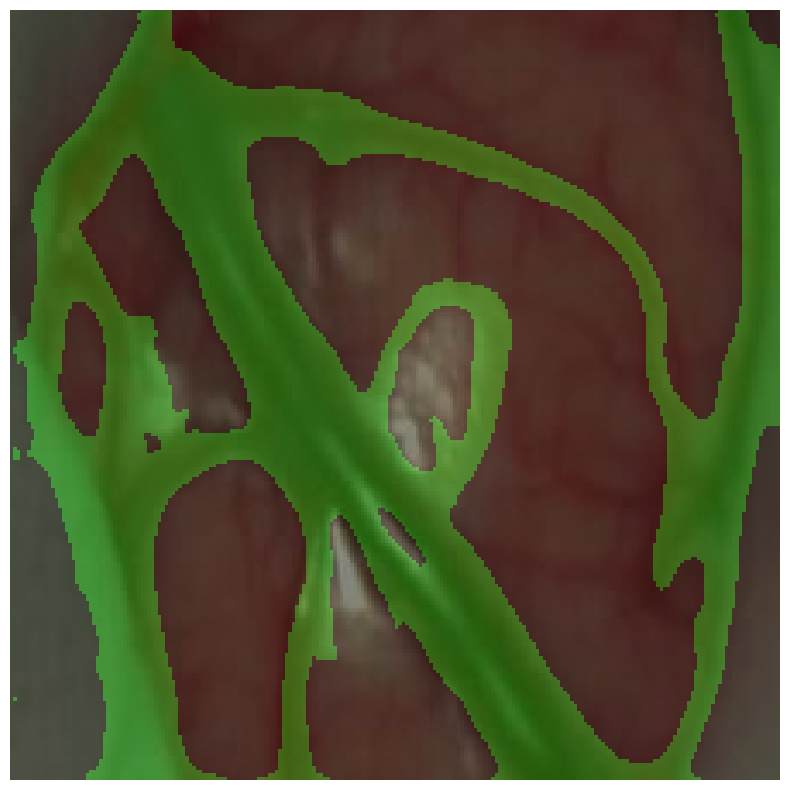

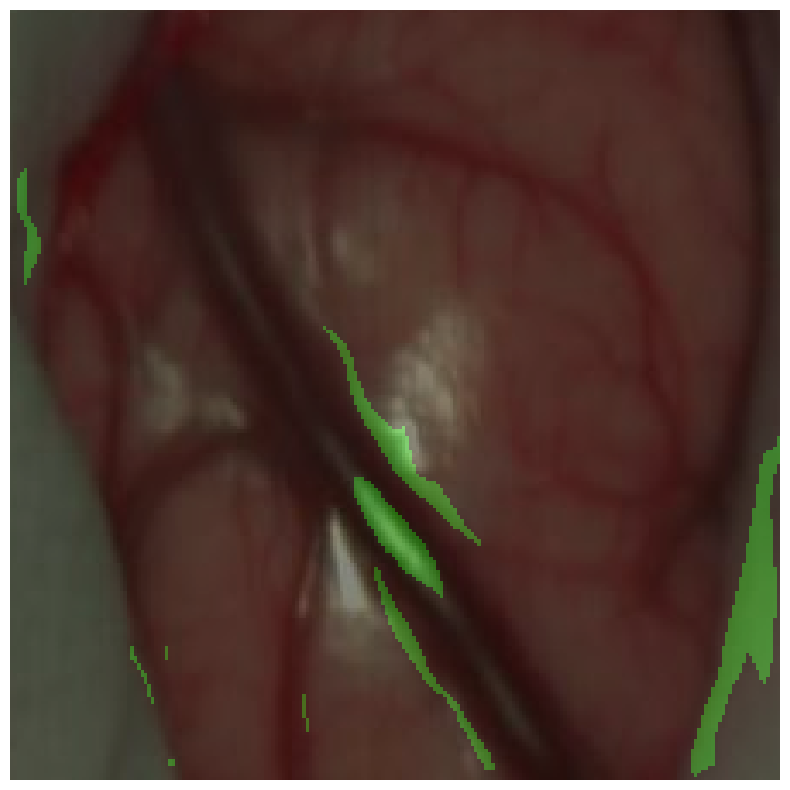

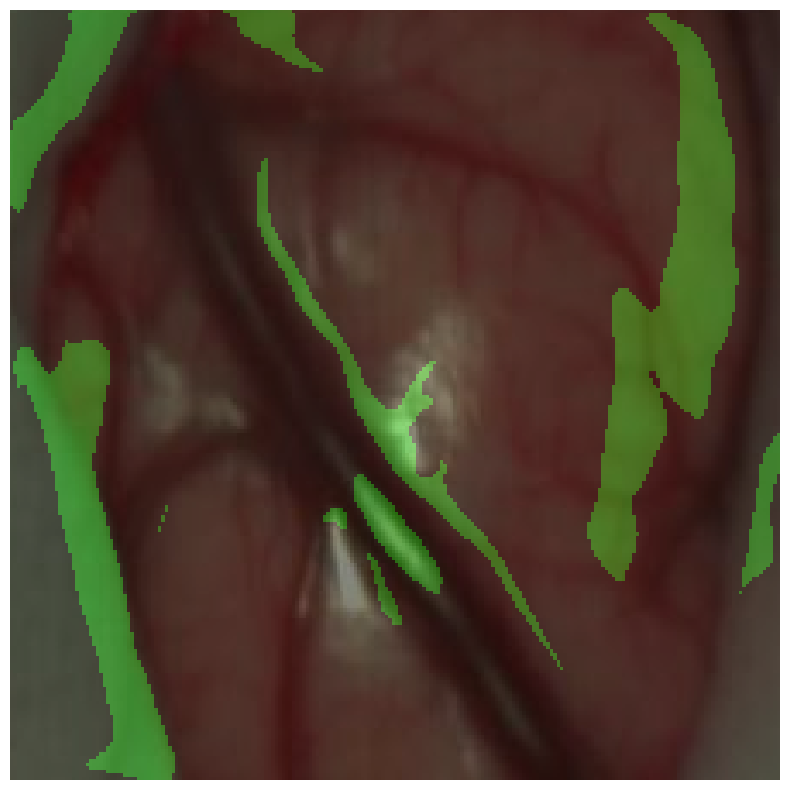

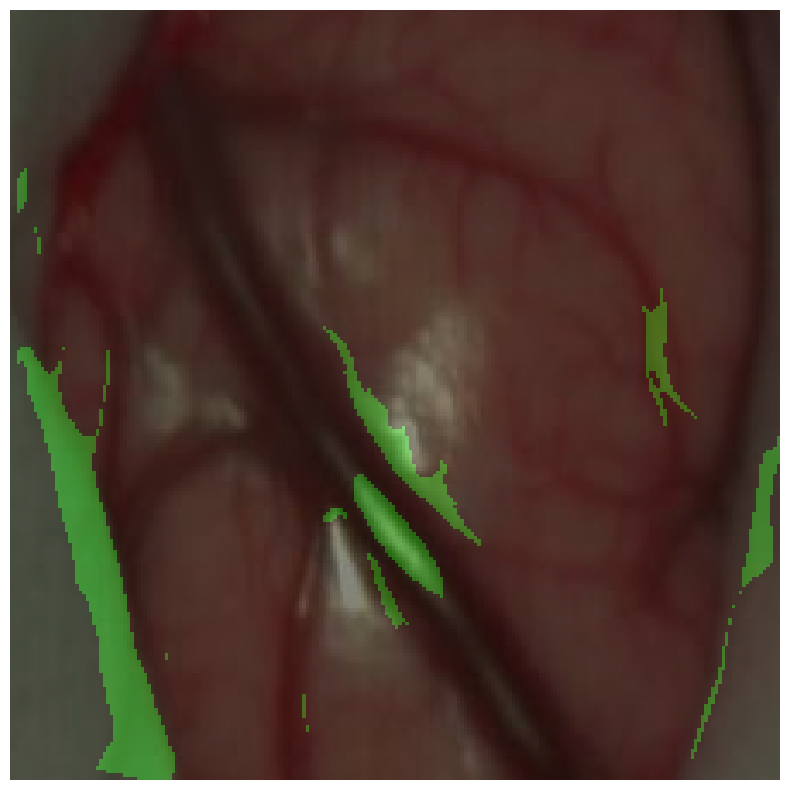

In [8]:
from HSI_Net import CombinedModel
from segmentation_util import predict, show_overlay
from autoencoder import Autoencoder
# from ensemble_model import EnsembleModelMajorityVoting, EnsembleModelAverage
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn

class EnsembleModelMajorityVoting(nn.Module):
    def __init__(self, models):
        super(EnsembleModelMajorityVoting, self).__init__()
        self.models = models

    def forward(self, x):
        # Get predictions from all models
        outputs = [model(x) for model in self.models]
        # Stack the outputs to get a tensor of shape (num_models, batch_size, num_classes, height, width)
        stacked_outputs = torch.stack(outputs)  # Shape: (num_models, batch_size, num_classes, height, width)
        # Apply softmax to get probabilities along the class dimension
        probabilities = torch.sigmoid(stacked_outputs)
        # Convert probabilities to binary predictions (assuming binary segmentation)
        binary_predictions = probabilities > 0.5
        # Perform majority voting along the num_models dimension
        majority_vote = torch.sum(binary_predictions.int(), dim=0) > (len(self.models) // 2)  # Shape: (batch_size, num_classes, height, width)
        return majority_vote.float()

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
autoencoder_single_channel = Autoencoder(output_channels=1)
autoencoder_single_channel.load_state_dict(torch.load('./models/autoencoder-single-channel-with-normalized-cropped-data.pth'))
autoencoder_single_channel.to(device)
autoencoder_single_channel.eval()

segmenter_single_channel = smp.UnetPlusPlus('timm-resnest200e', in_channels=1, classes=1)
segmenter_single_channel.load_state_dict(torch.load('./models/UnetPlusPlus-timm-resnest200e-512x512-augmented-with-random-crops-single-channel.pth'))
segmenter_single_channel.to(device)
segmenter_single_channel.eval()

model_single = CombinedModel(autoencoder_single_channel.encoder, segmenter_single_channel)
show_overlay(model_single, testset[0], device)

autoencoder_three_channels = Autoencoder(output_channels=3)
autoencoder_three_channels.load_state_dict(torch.load('./models/autoencoder-3-channels-with-normalized-cropped-data.pth'))
autoencoder_three_channels.to(device)
autoencoder_three_channels.eval()

segmenter_three_channels_mit = smp.Unet('mit_b5', in_channels=3, classes=1)
segmenter_three_channels_mit.load_state_dict(torch.load('./models/Unet-mit_b5-512x512-augmented-with-random-crops-3-channels.pth'))
segmenter_three_channels_mit.to(device)
segmenter_three_channels_mit.eval()

model_three_mit = CombinedModel(autoencoder_three_channels.encoder, segmenter_three_channels_mit)
show_overlay(model_three_mit, testset[0], device)

segmenter_three_channels_regnety = smp.UnetPlusPlus('timm-resnest200e', in_channels=3, classes=1)
segmenter_three_channels_regnety.load_state_dict(torch.load('./models/UnetPlusPlus-timm-resnest200e-512x512-augmented-with-random-crops-3-channels.pth'))
segmenter_three_channels_regnety.to(device)
segmenter_three_channels_regnety.eval()

model_three_regnety = CombinedModel(autoencoder_three_channels.encoder, segmenter_three_channels_regnety)
show_overlay(model_three_regnety, testset[0], device)

model = EnsembleModelMajorityVoting([model_single, model_three_mit, model_three_regnety])
output = model(testset[0][0].unsqueeze(0).to(device))

show_overlay(model, testset[0], device, with_sigmoid=False)

## Variational Autoencoder

In [ ]:
from autoencoder import model_pipeline_variational_autoencoder, VariationalAutoencoder
from torchsummary import summary

config = {
    'model': 'variational-autoencoder',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': trainloader.batch_size,
    'optimizer': 'Adam',
    'criterion': 'vae_loss',
}

vae = VariationalAutoencoder()
optimizer = torch.optim.Adam(vae.parameters(), lr=config['learning_rate'])
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

vae, train_losses, val_losses = model_pipeline_variational_autoencoder(vae,
                                                trainloader=trainloader, 
                                                validationloader=validationloader, 
                                                optimizer=optimizer,
                                                project='hsi-autoencoder',
                                                model_name=config['model'],
                                                device=device, 
                                                config=config, 
                                                batch_print=1)


# Mixed Approach:
The approach is to leverage transfer learning on eye fundus scans which are well labeled and look kind of similar to the bloodvessels inside the brain.

We use an autoencoder and input both the hsi scan and an eye fundus scan for dimensionality reduction of the hsi scan to one channel and also learning the structure of the bloodvessels with eye fundus scans and then use the pretrained model of the eye fundus scans.

Two branches:
- Input reduced hsi scans -> Reconstruct them
- Input FIVES images -> use loss of the groundtruth labels

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from dataset import HSIDataset
from dataset import SegmentationDataset, SegmentationDatasetWithRandomCrops
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize
import torch
import numpy as np
import torchvision.transforms as v2
import itertools

path = '../../home/ivan/HELICoiD/HSI_Human_Brain_Database_IEEE_Access/'

dataset = HSIDataset(path)
dataset.normalize_dataset()

# Autoencoder Split
train_indices = list(range(0, 32))
val_indices = list(range(32, 34))
test_indices = list(range(34, 36))

trainset_hsi = Subset(dataset, train_indices)
valset_hsi = Subset(dataset, val_indices)
testset_hsi = Subset(dataset, test_indices)

trainloader_hsi = DataLoader(trainset_hsi, batch_size=2, shuffle=True)
trainloader_hsi = itertools.cycle(trainloader_hsi)
validationloader_hsi = DataLoader(valset_hsi, batch_size=2, shuffle=False)
testloader_hsi = DataLoader(testset_hsi, batch_size=2, shuffle=False)

train_image_path = './FIVES/train/Original'
train_label_path = './FIVES/train/GroundTruth'
test_image_path = './FIVES/test/Original'
test_label_path = './FIVES/test/GroundTruth'

np.random.seed(42)

# Define transformations for images
image_transform = Compose([
    Grayscale(num_output_channels=1),  # Convert the image to grayscale
    Resize((512, 512)),                # Resize images to 512x512
    ToTensor(),                         # Convert the image to a PyTorch tensor
    # Normalize(mean=[0.3728, 0.1666, 0.0678], std=[0.1924, 0.0956, 0.0395])
    # Normalize(mean=[0.2147], std=[0.1163])   # Normalize the grayscale image
])

# Define transformations for labels, if needed
label_transform = Compose([
    Resize((512, 512)),  # Resize labels to 512x512
    ToTensor()           # Convert label to a tensor
])

dataset = SegmentationDataset(
    train_image_path, 
    train_label_path, 
    image_transform, 
    label_transform,
)

testset = SegmentationDataset(
    test_image_path, 
    test_label_path, 
    image_transform, 
    label_transform
)

# Prepare DataLoader
dataset, _ = random_split(dataset, [105, len(dataset) - 105])
train_size, val_size = int(0.9 * len(dataset)), int(0.1 * len(dataset) + 1)
train_indices = np.random.choice(len(dataset), train_size, replace=False)
val_indices = np.setdiff1d(np.arange(len(dataset)), train_indices)

train_dataset_fundus = Subset(dataset, train_indices)
val_dataset_fundus = Subset(dataset, val_indices)


print(f'Number of samples in the training set: {len(train_dataset_fundus)}, validation set: {len(val_dataset_fundus)}')
print(f'Number of samples in the test set: {len(testset)}')

trainloader_fundus = DataLoader(train_dataset_fundus, batch_size=4, shuffle=True, num_workers=8)
validationloader_fundus = DataLoader(val_dataset_fundus, batch_size=4, shuffle=False, num_workers=8)
testloader_fundus = DataLoader(testset, batch_size=4, shuffle=False, num_workers=8)

print(len(trainloader_fundus), len(validationloader_fundus), len(testloader_fundus))

Number of samples in the training set: 94, validation set: 11
Number of samples in the test set: 200
24 3 50


In [2]:
import wandb

def train_and_validate(encoder, segmenter, trainloader_hsi, trainloader_fundus, validationloader_hsi, validationloader_fundus, criterion_hsi, criterion_fundus, optimizer_encoder, optimizer_fundus, epochs=10, model_name=None, device='cuda', batch_print=10):
    """
    Function to train and validate
    Parameters
        :param segmenter: segmenter to train and validate
        :param loss_criterion: Loss Criterion_fundus to minimize
        :param optimizer_fundus: Optimizer_fundus for computing gradients
        :param epochs: Number of epochs (default=25)
        :param model_name: model file name (default=None)
    Returns
        train_losses, val_losses: List of losses per epoch
    """
    train_losses, val_losses = [], []
    min_val_loss = np.inf
    
    for epoch in range(epochs):
        segmenter.train()
        encoder.train()
        segmenter.to(device)
        encoder.to(device)
        running_loss = 0.0
        train_loss = 0.0
        for i, (hsi_data, fundus_data) in enumerate(zip(trainloader_hsi, trainloader_fundus)):
            fundus_img, labels_labels = fundus_data[0].to(device), fundus_data[1].to(device).float()
            outputs_fundus = segmenter(fundus_img)
            optimizer_fundus.zero_grad()
            loss_fundus = criterion_fundus(outputs_fundus, labels_labels)
            loss_fundus.backward()
            optimizer_fundus.step()

            hsi_img = hsi_data[0].to(device)
            reduced_hsi = encoder(hsi_img)
            outputs_hsi = segmenter(reduced_hsi)
            optimizer_encoder.zero_grad()
            optimizer_fundus.zero_grad()
            loss_hsi = criterion_hsi(outputs_hsi, reduced_hsi)
            loss_hsi.backward()
            optimizer_encoder.step()
            optimizer_fundus.step()

            running_loss += (loss_fundus.item() + loss_hsi.item()) / 2
            train_loss += (loss_fundus.item() + loss_hsi.item()) / 2

            if (i + 1) % batch_print == 0:  # Adjust the condition based on your preference
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / batch_print:.4f}')
                running_loss = 0.0  # Reset running loss after printing
                
        # Calculate and print the average loss per epoch
        train_loss = train_loss / (len(trainloader_fundus))
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')
        # wandb.log({"epoch":epoch+1, "train/loss": train_loss}, step=epoch+1)
        
        # Validation phase
        segmenter.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for i, (hsi_data, fundus_data) in enumerate(zip(validationloader_hsi, validationloader_fundus)):
                inputs, labels = fundus_data[0].to(device), fundus_data[1].to(device).float()
                outputs = segmenter(inputs)
                loss_fundus = criterion_fundus(outputs, labels)

                hsi_img = hsi_data[0].to(device)
                reduced_hsi = encoder(hsi_img)
                outputs_hsi = segmenter(reduced_hsi)
                loss_hsi = criterion_hsi(outputs_hsi, reduced_hsi)

                val_running_loss += (loss_fundus.item() + loss_hsi.item())/2
        
        val_loss = val_running_loss / (len(validationloader_fundus))
        val_losses.append(val_loss)

        if model_name:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(segmenter.state_dict(), f'./models/{model_name}_segmenter.pth')
                torch.save(encoder.state_dict(), f'./models/{model_name}_encoder.pth')
                # model_artifact = wandb.Artifact(f"{model_name}", type="model")
                # model_artifact.add_file(f'./models/{model_name}.pth')
                # wandb.log_artifact(model_artifact)

        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')
        # wandb.log({"epoch":epoch+1, "validation/loss": val_loss}, step=epoch+1)
    
    return train_losses, val_losses



/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Epoch 1, Batch 1, Loss: 61.9434
Epoch 1, Batch 2, Loss: 51.5176
Epoch 1, Batch 3, Loss: 45.7503
Epoch 1, Batch 4, Loss: 38.0545
Epoch 1, Batch 5, Loss: 30.2424
Epoch 1, Batch 6, Loss: 26.0860
Epoch 1, Batch 7, Loss: 21.6102
Epoch 1, Batch 8, Loss: 17.7662
Epoch 1, Batch 9, Loss: 14.8749
Epoch 1, Batch 10, Loss: 11.6172
Epoch 1, Batch 11, Loss: 10.4006
Epoch 1, Batch 12, Loss: 8.5387
Epoch 1, Batch 13, Loss: 7.6949
Epoch 1, Batch 14, Loss: 6.0121
Epoch 1, Batch 15, Loss: 4.0841
Epoch 1, Batch 16, Loss: 3.5426
Epoch 1, Batch 17, Loss: 3.2125
Epoch 1, Batch 18, Loss: 2.7111
Epoch 1, Batch 19, Loss: 2.4396
Epoch 1, Batch 20, Loss: 2.1158
Epoch 1, Batch 21, Loss: 2.1207
Epoch 1, Batch 22, Loss: 2.1104
Epoch 1, Batch 23, Loss: 1.6484
Epoch 1, Batch 24, Loss: 1.4495
Epoch 1, Train Loss: 15.7310
Epoch 1, Validation Loss: 2.0087
Epoch 2, Batch 1, Loss: 1.5524
Epoch 2, Batch 2, Loss: 1.3273
Epoch 2, Batch 3, Loss: 1.1567
Epoch 2, Batch 4, Loss: 0.9351
Epoch 2, Batch 5, Loss: 1.1184
Epoch 2, Batc

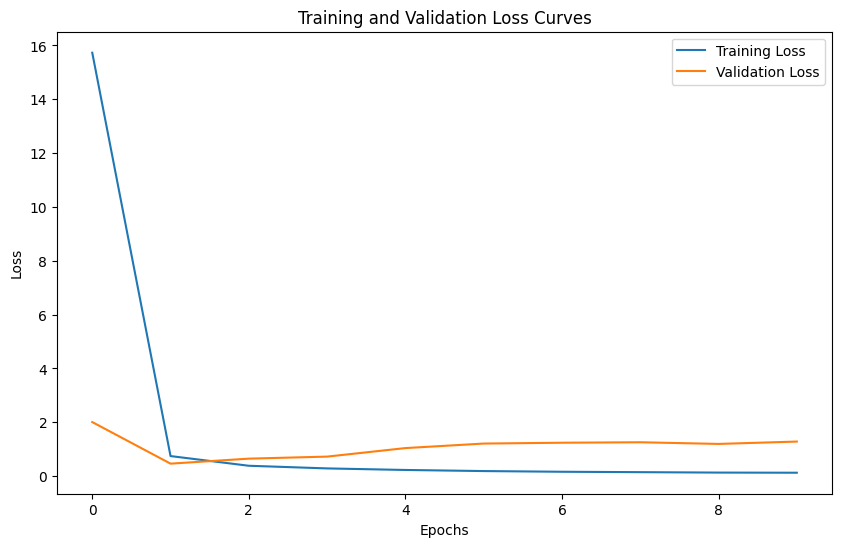

In [3]:
import segmentation_models_pytorch as smp
from autoencoder import Autoencoder
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

segmenter = smp.Unet('timm-resnest101e', in_channels=1, classes=1)
segmenter.load_state_dict(torch.load('./models/Unet-timm-resnest101e-512x512-augmented-with-random-crops-normalized_epoch10.pth'))
autoencoder = Autoencoder(output_channels=1)
autoencoder.load_state_dict(torch.load('./models/autoencoder-single-channel-with-cropped-data.pth'))

config = {
    'model': 'DualModel_encoder_with_mse',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': trainloader_fundus.batch_size,
    'optimizer': 'Adam',
    'criterion': 'MSELoss, DiceLoss',
}

autoencoder = Autoencoder(output_channels=1)

criterion_hsi = nn.MSELoss()
criterion_fundus = smp.losses.DiceLoss(mode='binary')

optimizer_fundus = torch.optim.Adam(segmenter.parameters(), lr=config['learning_rate'])
optimizer_encoder = torch.optim.Adam(autoencoder.encoder.parameters(), lr=config['learning_rate'])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_losses, val_losses = train_and_validate(encoder=autoencoder.encoder, 
                   segmenter=segmenter, 
                   trainloader_hsi=trainloader_hsi, 
                   trainloader_fundus=trainloader_fundus, 
                   validationloader_hsi=validationloader_hsi, 
                   validationloader_fundus=validationloader_fundus,
                   criterion_hsi=criterion_hsi,
                   criterion_fundus=criterion_fundus,
                   optimizer_encoder=optimizer_encoder,
                   optimizer_fundus=optimizer_fundus,
                   epochs=10,
                   model_name=config['model'],
                   device=device,
                   batch_print=1)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


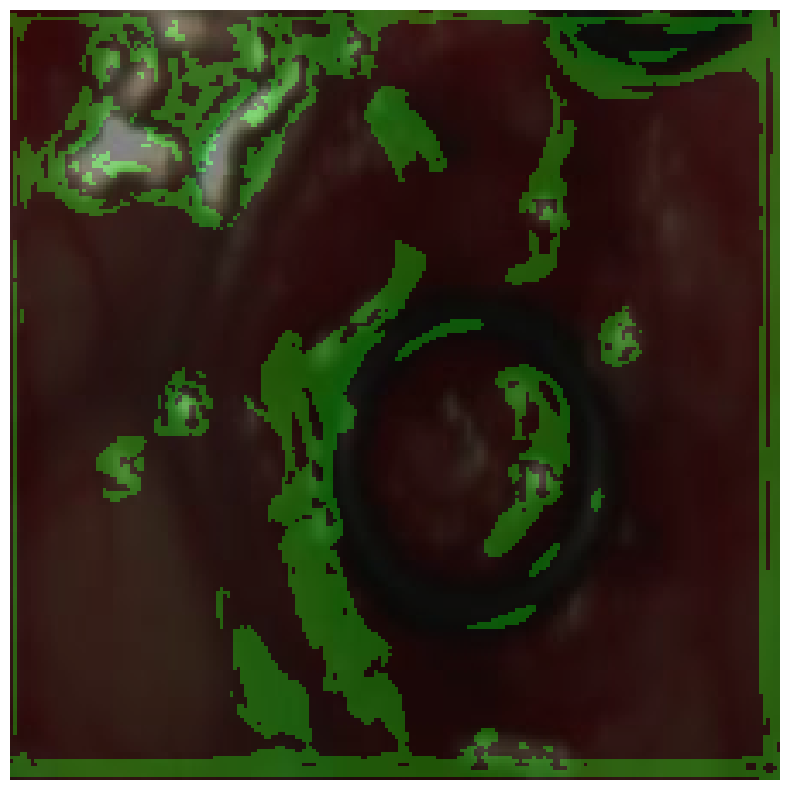

In [22]:
from HSI_Net import CombinedModel
from segmentation_util import predict, show_overlay
import cv2

# def show_overlay(model, data, device):
#     prediction = predict(model, data[0], device)
#     image = data[1].cpu().numpy().squeeze()
#     image = np.stack([image, image, image], axis=-1)
#     overlay = np.zeros_like(image)
#     overlay[prediction.cpu().numpy().squeeze(0) == 1] = [0, 255, 0]
#     combined = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
    
#     plt.figure(figsize=(10, 10))
#     plt.imshow(combined, cmap='gray')
#     plt.axis('off')  # Turn off axis numbers and ticks
#     plt.show()

segmenter = smp.Unet('timm-resnest101e', in_channels=1, classes=1)
segmenter.load_state_dict(torch.load('./models/DualModel_encoder_with_mse_segmenter.pth'))
autoencoder = Autoencoder(output_channels=1)
autoencoder.encoder.load_state_dict(torch.load('./models/DualModel_encoder_with_mse_encoder.pth'))

model = CombinedModel(autoencoder.encoder, segmenter)
show_overlay(model, trainset_hsi[22], device)